Cài đặt các thư viện cần thiết để phục vụ đề tài
Thư viện numpy,pandas làm việc với file dữ liệu
Thư viện matplotlib để hiển thị hình ảnh, đồ thị
Thư viện ta, vnstock để truy cập và tải dữ liệu trực tuyến



In [2]:
!pip install backtesting ta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from ta.trend import sma_indicator
!pip install vnstock
from vnstock import stock_historical_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=35a3f66ff299579ad9155e0b72803c754acd0a84f5b50e4e1ef3de826e611a47
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=9cdba4262229b6dab95b8c5b0f831837933ce544a4c708c47801fb8f2021621d
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built backtesting ta


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Sử dụng pandas để lấy dữ liệu và hiển thị dữ liệu


In [3]:
# Get stock data for CTG
df = stock_historical_data('CTG', '2018-01-01', '2024-01-01')
df.columns = ['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker']
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

Câu 1
Xây dựng chiến thuật giao dịch dựa trên đường SMA(ngắn hạn) và đường SMA(dài hạn). Cụ thể, khi đường SMA(ngắn hạn) cắt từ dưới lên đường SMA(dài hạn) là tín hiệu "Mua". Trong khi,đường SMA(ngắn hạn) cắt từ trên xuống đường SMA(dài hạn) là tín hiệu "Bán"

In [4]:

# Tính toán SMA(20) and SMA(40)
df['SMA_20'] = sma_indicator(close=df['Close'], window=20)
df['SMA_40'] = sma_indicator(close=df['Close'], window=40)

# Tín hiệu trading
df['position'] = 0
df.loc[(df['SMA_20'] > df['SMA_40']) & (df['SMA_20'].shift(1) <= df['SMA_40'].shift(1)), 'position'] = 1
df.loc[(df['SMA_20'] < df['SMA_40']) & (df['SMA_20'].shift(1) >= df['SMA_40'].shift(1)), 'position'] = -1

Câu 2
Vẽ đồ thị biểu diễn giá đóng cửa của cổ phiếu CTG, đường SMA(20) và đường SMA(40) cho 900 điểm quan sát trong giai đoạn trên.
Xác định các điểm
giao nhau giữa hai đường SMA(20) và SMA(40) trên toàn bộ chuỗi giá của CTG

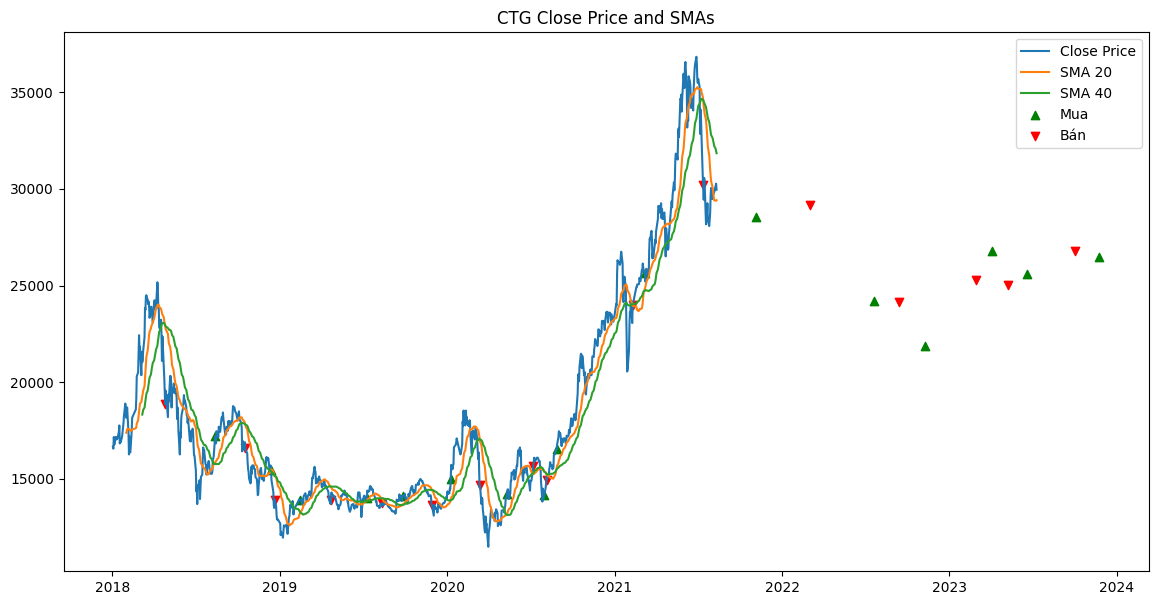

Số điểm giao nhau: 32


In [5]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(df.index[:900], df['Close'][:900], label='Close Price')
plt.plot(df.index[:900], df['SMA_20'][:900], label='SMA 20')
plt.plot(df.index[:900], df['SMA_40'][:900], label='SMA 40')
plt.scatter(df.index[df['position'] == 1][:900], df['Close'][df['position'] == 1][:900], label='Mua', marker='^', color='g')
plt.scatter(df.index[df['position'] == -1][:900], df['Close'][df['position'] == -1][:900], label='Bán', marker='v', color='r')
plt.title('CTG Close Price and SMAs')
plt.legend()
plt.show()
crossings = df['position'].value_counts().get(1, 0) + df['position'].value_counts().get(-1, 0)
print(f'Số điểm giao nhau: {crossings}')



Câu 3
Với số tiền đầu tư là 100.000.000 đồng, giả sử phí giao dịch là 0.1%, xác định đường SMA(ngắn hạn) và đường SMA(dài hạn) để nhà đầu tư có thể kiếm được số tiền nhiều nhất sau khi thực hiện chiến thuật giao dịch dựa trên đường SMA. Lưu ý, SMA(ngắn hạn) chỉ được xác định từ 10 đến 20 ngày, SMA(dài hạn) chỉ được xác định từ 30 đến 50 ngày
Phạm vi từ 10-20 ngày và 30-50 ngày nghĩa là giới hạn trên của các vòng lặp nên là 21 và 51. Điều này để đảm bảo rằng các giá trị bao gồm cả ngày 20 và ngày 50 trong phạm vi được xét.

In [8]:
def calculate_profit(sma_short, sma_long):
    df['SMA_short'] = sma_indicator(close=df['Close'], window=sma_short)
    df['SMA_long'] = sma_indicator(close=df['Close'], window=sma_long)
    df['position'] = 0
    df.loc[(df['SMA_short'] > df['SMA_long']) & (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1)), 'position'] = 1
    df.loc[(df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1)), 'position'] = -1

    # Đầu tư giả thiết
    cash = investment
    holdings = 0

    for i in range(1, len(df)):
        if df['position'][i] == 1:  # Mua
            shares_to_buy = cash // df['Close'][i]
            holdings += shares_to_buy
            cash -= shares_to_buy * df['Close'][i] * (1 + fee)
        elif df['position'][i] == -1:  # Bán
            cash += holdings * df['Close'][i] * (1 - fee)
            holdings = 0

    # Xuất giá trị
    portfolio_value = cash + holdings * df['Close'].iloc[-1]
    return portfolio_value

# Khai báo giá trị đầu tư và phí
investment = 100000000  # VND
fee = 0.001  # 0.1%

best_profit = 0
best_sma_short = 0
best_sma_long = 0
results = []

# Tìm SMA tốt nhất
for sma_short in range(10, 21): # 10-20 ngày
    for sma_long in range(30, 51): # 30-50 ngày
        profit = calculate_profit(sma_short, sma_long)
        results.append((sma_short, sma_long, profit))
        if profit > best_profit:
            best_profit = profit
            best_sma_short = sma_short
            best_sma_long = sma_long

print(f'SMA ngắn tốt nhất: {best_sma_short}, SMA dài tốt nhất: {best_sma_long}, Lợi nhuận tốt nhất: {best_profit}')



SMA ngắn tốt nhất: 19, SMA dài tốt nhất: 30, Lợi nhuận tốt nhất: 230568031.42000046


Để chứng minh lựa chọn tốt nhất
Tính toán lợi nhuận cho tất cả các tổ hợp SMA:
Chạy chiến lược giao dịch cho tất cả các tổ hợp của SMA ngắn hạn và SMA dài hạn và lưu lại lợi nhuận tương ứng.
Tìm tổ hợp SMA có lợi nhuận cao nhất: Xác định tổ hợp SMA nào mang lại lợi nhuận cao nhất.
So sánh lợi nhuận của tổ hợp tốt nhất với các tổ hợp khác: Đảm bảo rằng lợi nhuận của tổ hợp SMA tốt nhất lớn hơn hoặc bằng lợi nhuận của tất cả các tổ hợp SMA khác.

 SMA_short  SMA_long      Profit
        19        30 230,568,031
        19        31 221,554,140
        20        35 215,545,202
        18        32 211,799,286
        18        30 211,693,963
        18        31 206,075,228
        16        32 204,535,545
        19        38 204,096,614
        14        30 202,720,243
        13        50 202,236,964
        20        37 200,972,431
        17        32 200,840,575
        19        36 198,907,209
        19        37 198,713,782
        16        33 197,074,788
        15        30 196,340,749
        15        31 196,107,586
        19        39 195,487,641
        17        31 195,474,975
        19        33 194,951,585
        20        36 194,504,432
        14        44 193,682,685
        19        35 193,000,612
        17        33 192,888,273
        17        30 192,453,481
        13        32 192,242,760
        18        33 192,130,131
        13        30 191,772,150
        14        43 191,380,229
        20

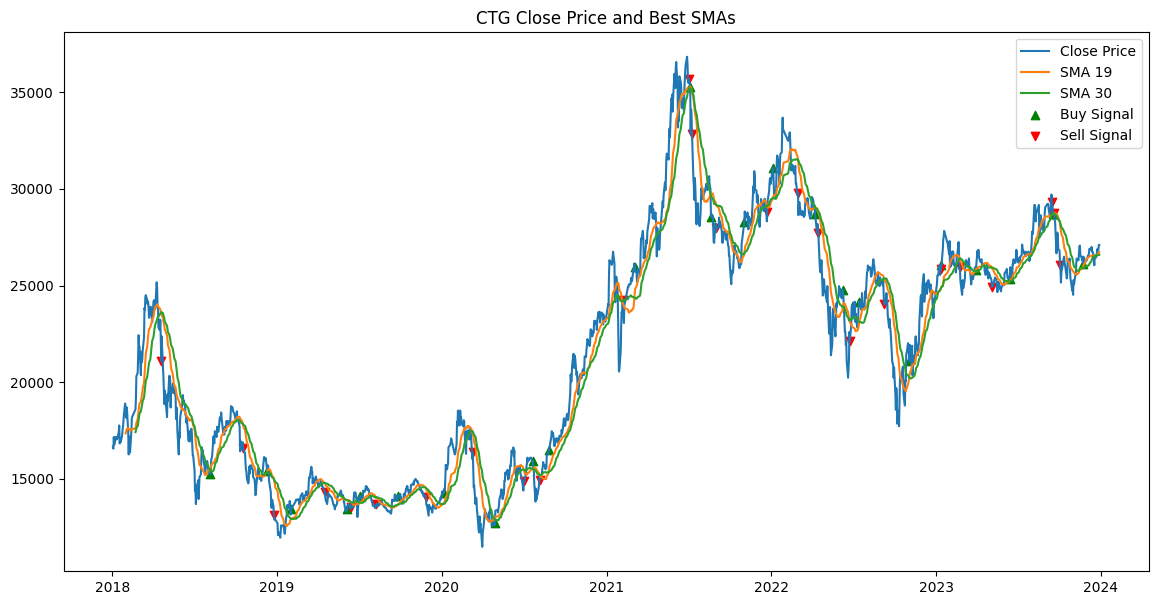

In [9]:
# Chứng minh chiến lược vừa chọn là tốt nhất

results_df = pd.DataFrame(results, columns=['SMA_short', 'SMA_long', 'Profit'])
results_df.sort_values(by='Profit', ascending=False, inplace=True)

# Hiển thị kết quả với số nguyên
print(results_df.to_string(index=False, formatters={'Profit': '{:,.0f}'.format}))


# Plotting
plt.figure(figsize=(14, 7))
df['SMA_short'] = sma_indicator(close=df['Close'], window=best_sma_short)
df['SMA_long'] = sma_indicator(close=df['Close'], window=best_sma_long)
df['position'] = 0
df.loc[(df['SMA_short'] > df['SMA_long']) & (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1)), 'position'] = 1
df.loc[(df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1)), 'position'] = -1
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['SMA_short'], label=f'SMA {best_sma_short}')
plt.plot(df.index, df['SMA_long'], label=f'SMA {best_sma_long}')
plt.scatter(df.index[df['position'] == 1], df['Close'][df['position'] == 1], label='Buy Signal', marker='^', color='g')
plt.scatter(df.index[df['position'] == -1], df['Close'][df['position'] == -1], label='Sell Signal', marker='v', color='r')
plt.title('CTG Close Price and Best SMAs')
plt.legend()
plt.show()

Câu 4
Xác định thời gian rút vốn tối đa (max drawdown duration) trên toàn bộ chuỗi giá của CTG

In [10]:
def max_drawdown_duration(prices):
    max_duration = 0
    peak = prices.iloc[0]
    trough = prices.iloc[0]
    peak_time = prices.index[0]
    for time, price in prices.items():
        if price > peak:
            peak = price
            peak_time = time
        elif price < trough:
            trough = price
            duration = (time - peak_time).days
            max_duration = max(max_duration, duration)
        peak = max(peak, price)
        trough = min(trough, price)
    return max_duration

drawdown_duration = max_drawdown_duration(df['Close'])
print(f'Thời gian rút vốn tối đa: {drawdown_duration} days')

Thời gian rút vốn tối đa: 722 days


Câu 5

In [11]:
# Hàm tính MACD và MACD signal
def calculate_macd(close, short_window=12, long_window=26, signal_window=9):
    ema12 = close.ewm(span=short_window, adjust=False).mean()
    ema26 = close.ewm(span=long_window, adjust=False).mean()
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, macd_signal

# Hàm crossover
def crossover(series1, series2):
    return series1[-2] < series2[-2] and series1[-1] > series2[-1]

# Đảm bảo không có giá trị bị thiếu
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Chiến lược MACD
class MACDStrategy(Strategy):
    def init(self):
        close = pd.Series(self.data.Close)
        self.macd, self.macd_signal = self.I(calculate_macd, close)

    def next(self):
        if crossover(self.macd, self.macd_signal):
            self.buy()
        elif crossover(self.macd_signal, self.macd):
            self.position.close()

macd_bt = Backtest(
    df,
    MACDStrategy,
    cash=100000,
    commission=0.002,
    trade_on_close=True,
    exclusive_orders=True
)
macd_stats = macd_bt.run()
print(f'MACD strategy profit: {macd_stats["Equity Final [$]"]}')

# Chiến lược SMA 20/40
class SMA20SMA40Strategy(Strategy):
    def init(self):
        self.sma20 = self.I(lambda x: pd.Series(x).rolling(window=20).mean().values, self.data.Close)
        self.sma40 = self.I(lambda x: pd.Series(x).rolling(window=40).mean().values, self.data.Close)

    def next(self):
        if crossover(self.sma20, self.sma40):
            self.buy()
        elif crossover(self.sma40, self.sma20):
            self.position.close()

sma_bt = Backtest(
    df,
    SMA20SMA40Strategy,
    cash=100000,
    commission=0.002,
    trade_on_close=True,
    exclusive_orders=True
)
sma_stats = sma_bt.run()
print(f'SMA strategy profit: {sma_stats["Equity Final [$]"]}')

MACD strategy profit: 157834.02000000008
SMA strategy profit: 177165.62
